In [2]:
# First we import the required libraries
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [4]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
df = pd.read_csv('Data/liar_dataset/train.tsv', sep='\t', header=None)
df = df.fillna(' ')
df.columns = ['ID', 'label', 'statement', 'subject','speaker',
              'speaker_job','state','party','barely_true_counts','false_counts','half_true_counts','mostly_true_counts',
             'pants_on_fire_counts','venue']
df.count()

ID                      10240
label                   10240
statement               10240
subject                 10240
speaker                 10240
speaker_job             10240
state                   10240
party                   10240
barely_true_counts      10240
false_counts            10240
half_true_counts        10240
mostly_true_counts      10240
pants_on_fire_counts    10240
venue                   10240
dtype: int64

In [6]:
df.head()

,ID,label,statement,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN


In [5]:
# Add punctuations support.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update('!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~')
# Add Unicode characters support.
for i in range(1000, 1100):
    stop_words.update(chr(i))


# read in reviews from the NLTK corpora directory
statement_col  = []
for statement in df['statement']:
  cleaned_statement = ''
  for word in statement.split():
    if word.lower() not in stop_words:
      cleaned_statement += word.lower() + ' '
      cleaned_statement = cleaned_statement.replace('\n','')
  statement_col.append(cleaned_statement)
df['Cleaned Statement'] = statement_col

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Tokenize text

tokenizer = Tokenizer() # Using keras libary for tokenizing df[text]
tokenizer.fit_on_texts(df['Cleaned Statement'])
word_index = tokenizer.word_index # Dictionary of all unique words and their counts
vocab_size=len(word_index)
print('Vocab size', vocab_size) # 238051 unique words in the dataset

# Padding data
sequences = tokenizer.texts_to_sequences(df['Cleaned Statement']) # list of list
# MIGHT CAUSE ISSUE
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post') # Cap each text to length 500
# df['padded'] = ['None']*len(df)
# for i,row in df.iterrows():
#   row['padded'] = padded[i]

Vocab size 12383


In [8]:
labels = df['label']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
print('class mapping:', encoder.classes_)
# convert integers to dummy variables (i.e. one hot encoded)
labels = np_utils.to_categorical(encoded_Y)
df['encoded_labels'] = ['None']*len(df)
for i,row in df.iterrows():
  row['encoded_labels'] = labels[i]

class mapping: ['barely-true' 'false' 'half-true' 'mostly-true' 'pants-fire' 'true']


In [9]:
print('Pre padding',len(sequences[5]))
print('Post padding',len(padded[5]))

Pre padding 16
Post padding 100


In [10]:
# Splitting
split = 0.2

split_n = int(len(df)*0.2)
train_data = padded[:split_n]
train_labels = labels[:split_n]
test_data = padded[split_n:]
test_labels = labels[split_n:]

#train, test = train_test_split(df, test_size=split, random_state=6)
# train_data = train['padded'] # Train data: text
# train_labels = train['encoded_labels'] # Train label: fake news or not
# test_data = test['padded'] # Test data 
# test_labels = test['encoded_labels'] # Test label

In [11]:
# Import tensor representations for words

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {}; # Define a dictionary to store the embeddings
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0]; # First index is the word
        coefs = np.asarray(values[1:], dtype='float32'); # Rest of them are the embeddings
        embeddings_index[word] = coefs; # Create the key value pair
print('Length of embedding:', len(coefs)) # Embeddings have lengh 100

embeddings_matrix = np.zeros((vocab_size+1, 100)); # Matrix size is row:238051 X column:100
for word, i in word_index.items(): # Iterate all unique word in the corpus
    embedding_vector = embeddings_index.get(word); # Matches the word in corpus to embedding
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector; # Build a matrix of each word with embedding

--2020-11-11 15:18:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  88.4MB/s    in 3.7s    

2020-11-11 15:18:54 (88.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

Length of embedding: 100


In [12]:
train_data[0].shape

(100,)

In [13]:
# Build the architecture of the model

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
METRICS = ['accuracy']
CALLBACKS = [lr_reduce, early_stopping_cb]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2), # Regularization to prevent overfitting
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True), # Dimensionality of the output space
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1238400   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

In [14]:
# Training model
history = model.fit(train_data, 
                    train_labels, 
                    epochs=25, 
                    batch_size=100, 
                    validation_split=0.2,
                    callbacks=CALLBACKS)

print("Training Complete")

Epoch 1/25
17/17 [==============================] - 1s 81ms/step - loss: 1.7759 - accuracy: 0.1856 - val_loss: 1.7739 - val_accuracy: 0.2098
Epoch 2/25
17/17 [==============================] - 0s 18ms/step - loss: 1.7622 - accuracy: 0.2039 - val_loss: 1.7727 - val_accuracy: 0.2049
Epoch 3/25
17/17 [==============================] - 0s 18ms/step - loss: 1.7574 - accuracy: 0.2082 - val_loss: 1.7642 - val_accuracy: 0.2195
Epoch 4/25
17/17 [==============================] - 0s 18ms/step - loss: 1.7465 - accuracy: 0.2186 - val_loss: 1.7523 - val_accuracy: 0.2244
Epoch 5/25
17/17 [==============================] - 0s 18ms/step - loss: 1.7269 - accuracy: 0.2375 - val_loss: 1.7456 - val_accuracy: 0.2268
Epoch 6/25
17/17 [==============================] - 0s 18ms/step - loss: 1.7151 - accuracy: 0.2509 - val_loss: 1.7345 - val_accuracy: 0.2366
Epoch 7/25
17/17 [==============================] - 0s 20ms/step - loss: 1.6805 - accuracy: 0.2845 - val_loss: 1.7231 - val_accuracy: 0.2439
Epoch 8/25
17

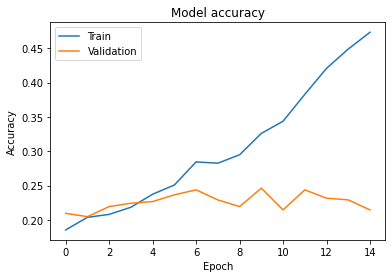

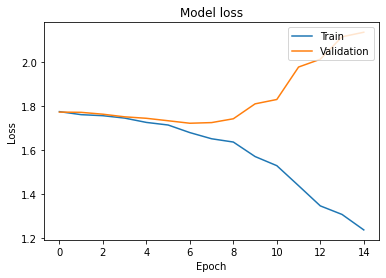

In [15]:
# Validate model performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_pred_test = model.predict(test_data)

In [ ]:
y_pred_test

array([[0.1559041 , 0.29361266, 0.14608341, 0.15105943, 0.09390116,
        0.15943927],
       [0.13135526, 0.06951997, 0.3173992 , 0.28358632, 0.03855009,
        0.15958917],
       [0.13402109, 0.20634541, 0.18909945, 0.23455974, 0.04834367,
        0.18763068],
       ...,
       [0.18275051, 0.14731263, 0.22274174, 0.17383856, 0.12226007,
        0.15109654],
       [0.1458977 , 0.30170774, 0.14284465, 0.1634034 , 0.07812826,
        0.1680182 ],
       [0.20057112, 0.12383425, 0.15902393, 0.09226951, 0.3189164 ,
        0.10538482]], dtype=float32)

In [ ]:
test_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)